## Feature Extaction Test

In [1]:
import sys; sys.path.insert(0, '..')
from database.dataset import *

from feature_extraction.feature_extraction import CandidatesFeatureExtraction
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from general_utils.plots import plot_bboxes_over_image, simple_im_show, simple_im_show2
from metrics.metrics import get_tp_fp_fn, quick_circle_comparison, circle_comparison

from general_utils.plots import plot_gabor_filters


### Database initialization

In [2]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        max_lesion_diam_mm=10000000.0,
        partitions=['train'],
        min_breast_fraction_roi=0.5,
        normalize=None,
        n_jobs=-1,
)

### Detectors Parameters and initialization

In [3]:
dehazing_params = {'omega': 0.9, 'window_size': 11, 'radius': 40, 'eps': 1e-5}

hough1_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 8,  'minRadius': 2, 'maxRadius': 20}

hough2_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 10,  'minRadius': 2, 'maxRadius': 20}

back_ext_radius = 50

erosion_iter = 20
erosion_size = 5


hd = HoughCalcificationDetection(dehazing_params, back_ext_radius,
                                 Path.cwd().parent / 'data/hough_img'
                                 hough1_params, hough2_params,
                                 erosion_iter=erosion_iter,
                                 erosion_size=erosion_size)


### Detector initialization

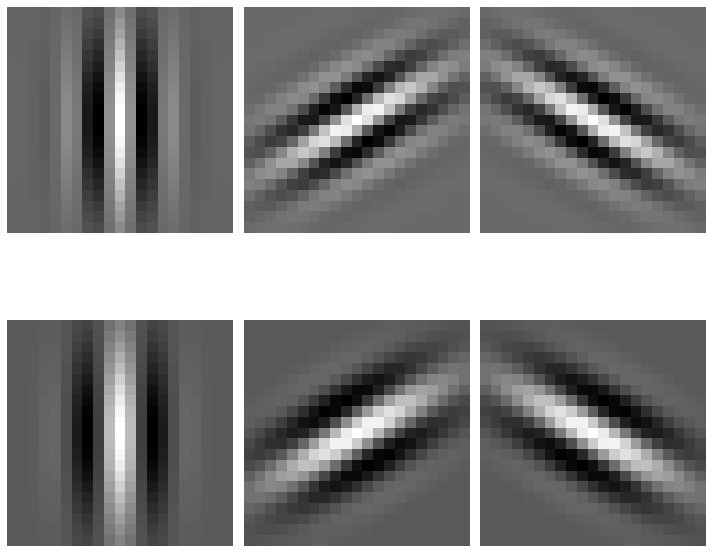

In [4]:
# FE class initialization
gabor_params = {'scale':2, 'orientation':3, 'max_freq':0.2, 'ksize':(20, 20), 'sigma':3}

cfe  = CandidatesFeatureExtraction(patch_size=14, gabor_params=gabor_params)
gabor_fb = cfe.gabor_feature_bank(**gabor_params)
plot_gabor_filters(gabor_fb)


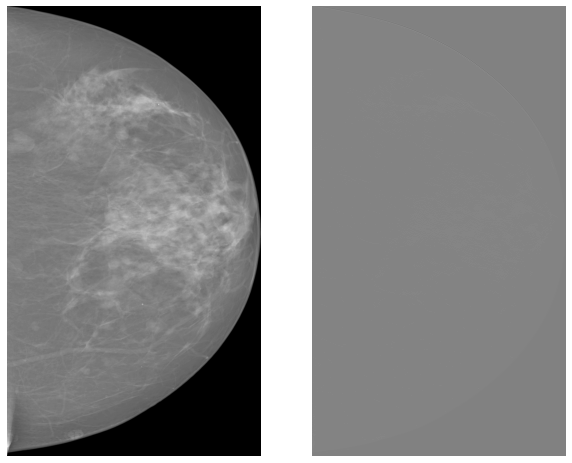

In [5]:
image = db[0]['img']
simple_im_show2(image, cv2.filter2D(image, cv2.CV_32F, gabor_fb[4]))

### FE

In [6]:
idx = 0
fdf = []
for idx in tqdm(range(len(db))):
    # extracting data
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db.df.iloc[idx].img_id
    image_mask = db_sample['lesion_mask']

    # candidate selection
    h1_circles = hd.detect(image, image_id, load_processed_images=True, hough2=False)[0]

    # feature extraction
    res = pd.DataFrame(cfe.extract_features(h1_circles, image, image_mask, fp2tp_sample=None))
    res['img_id'] = image_id
    
    # classification
    
    fdf.append(res)

100%|██████████| 162/162 [08:59<00:00,  3.33s/it]


In [7]:
pd.to_pickle(fdf, 'gabor_train_all_14px_big_diam_size.pkl')

### Classification

Mostly to check how extracted features work

In [8]:
from sklearn.svm import SVC

from sklearn.metrics import f1_score, roc_auc_score

from sklearn.preprocessing import MinMaxScaler

In [9]:
all_data_df = pd.concat(fdf).sample(frac=1) # merge and shuffle
data = all_data_df.drop(columns=['candidate_coordinates', 'patch_coordinates'])
data.head(10)

,img_energy,img_entropy,img_uniformity,img_min,img_10th_perc,img_90th_perc,img_max,img_mean,img_meadian,img_inter_quartile_range,...,std_4,skew_4,kurt_4,energy_5,mean_5,std_5,skew_5,kurt_5,patch_mask_intersection,img_id
604,92.607853,6.836300,0.009944,0.629744,0.657546,0.722418,0.657546,0.686952,0.684025,0.028354,...,0.086081,0.458429,0.349870,933.819702,2.165920,0.270515,0.262480,-0.875297,0,24065914
46,151.797515,6.839641,0.010360,0.798021,0.848403,0.911606,0.848403,0.879706,0.878093,0.035762,...,0.145241,0.091725,-1.059251,1438.439819,2.700872,0.210398,-0.070329,-1.113444,0,24065860
53,129.961467,6.823594,0.010256,0.760890,0.784291,0.843142,0.784291,0.813962,0.814180,0.029194,...,0.188924,-0.065096,-0.482460,1240.146851,2.507758,0.196036,-0.010465,-0.936745,0,20587902
1400,83.197753,7.101805,0.008017,0.574153,0.611405,0.687853,0.611405,0.650863,0.651130,0.038577,...,0.148180,-0.592047,-0.119192,800.778442,2.004217,0.262144,-0.107957,-1.038423,0,27829188
1147,95.933690,6.640562,0.011401,0.627521,0.676378,0.722994,0.676378,0.699272,0.699462,0.026109,...,0.082712,-0.070065,0.155091,941.149231,2.185038,0.165502,-0.234612,-0.398843,0,22579893
965,59.151214,6.647424,0.011349,0.506410,0.530627,0.566774,0.530627,0.549163,0.550392,0.020655,...,0.093330,-0.048216,-0.711735,550.103638,1.672277,0.100700,-0.249333,-0.237178,0,24065434
74,136.050644,6.617439,0.012026,0.791150,0.807080,0.857080,0.807080,0.832942,0.834292,0.026438,...,0.135824,-0.333270,-0.219361,1309.234863,2.579451,0.161871,0.269999,-0.252142,0,20587784
1653,34.378038,6.430769,0.013276,0.396661,0.407260,0.430180,0.407260,0.418715,0.418389,0.012056,...,0.046503,0.014684,-0.740584,330.391235,1.296505,0.068877,0.107956,-0.595808,0,24055958
1149,99.366074,6.733881,0.011297,0.661184,0.688414,0.735015,0.688414,0.711755,0.711988,0.023575,...,0.088245,-0.322999,0.825668,955.276489,2.204257,0.122920,-0.176004,-0.269934,0,22614431
832,70.299480,6.683238,0.010933,0.563923,0.581961,0.616637,0.581961,0.598745,0.598249,0.018651,...,0.085267,-0.177963,-0.813629,684.444824,1.855893,0.218461,-0.130573,-1.264739,0,30011674


In [10]:
data_backed_up = data.copy()

Resampling data to 1:1 split for TP/FP for a nice training

In [11]:
pos_data = data[data.patch_mask_intersection>0]
neg_data = data[data.patch_mask_intersection==0].sample(len(pos_data))

# candidates split with 1:1 correspondace between FP and TP
data = pd.concat([pos_data, neg_data]).sample(frac=1)
data

,img_energy,img_entropy,img_uniformity,img_min,img_10th_perc,img_90th_perc,img_max,img_mean,img_meadian,img_inter_quartile_range,...,std_4,skew_4,kurt_4,energy_5,mean_5,std_5,skew_5,kurt_5,patch_mask_intersection,img_id
958,103.306477,6.589542,0.011870,0.685518,0.704156,0.747215,0.704156,0.725812,0.725578,0.020566,...,0.172950,0.058244,-1.067655,1001.784668,2.251574,0.203866,0.289521,-0.304553,0,20588072
617,41.482971,6.582645,0.011429,0.486776,0.525349,0.567964,0.525349,0.544065,0.541605,0.023848,...,0.087845,0.043083,-0.616872,398.091614,1.677921,0.167611,-0.125508,-1.202006,0,20587200
457,98.800530,6.794974,0.010100,0.644214,0.681347,0.738342,0.681347,0.709567,0.712435,0.032060,...,0.151610,0.051849,-1.042383,1009.035828,2.260517,0.195459,0.113234,-0.631129,0,20587928
413,74.668631,6.966451,0.009007,0.557427,0.587672,0.651225,0.587672,0.616753,0.615812,0.032542,...,0.112980,0.235780,-0.378493,714.751099,1.901256,0.178648,0.741493,0.018844,0,22678953
424,118.683841,6.552377,0.012391,0.740183,0.756164,0.800913,0.756164,0.777926,0.776256,0.023288,...,0.169611,0.387107,-0.439211,1144.972290,2.393502,0.335925,0.369535,-0.936246,0,26933801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,78.989189,6.992061,0.008642,0.588298,0.605496,0.665603,0.605496,0.634404,0.632624,0.035195,...,0.204112,0.027378,-0.839770,760.816895,1.942768,0.327678,0.581952,-0.369906,196,22670465
1233,35.836588,6.657237,0.011922,0.397408,0.408979,0.447701,0.408979,0.427342,0.425640,0.015813,...,0.166755,0.209066,-0.490672,349.533569,1.319184,0.207578,0.783665,-0.236168,0,22679036
743,49.618700,6.445379,0.012472,0.563160,0.599745,0.656534,0.599745,0.627129,0.627594,0.031398,...,0.068688,-0.221417,-1.011342,479.669037,1.943585,0.171396,-0.322236,-1.198238,0,22614499
23,127.269364,6.687931,0.011454,0.752902,0.780058,0.830846,0.780058,0.805539,0.802861,0.028711,...,0.128830,-0.138232,-0.904229,1220.964355,2.487079,0.209400,0.424393,-0.778233,22,22613970


In [12]:
f1_metrics = []
rocauc_metrics = []

full_test_prediction = []
# LOO cross validation per patient 
data_case_ids = db.df[db.df.img_id.isin(data.img_id.unique())].case_id.unique()
for test_case_id in tqdm(data_case_ids):
    test_img_ids = db.df[db.df.case_id == test_case_id].img_id.values
    test_mask = data.img_id.isin(test_img_ids)
    
    train_df = data[~test_mask]
    test_df = data[test_mask]

    train_X, train_y = train_df.drop(columns=['patch_mask_intersection', 'img_id']), (train_df.patch_mask_intersection>0).values.astype(int)
    test_X, test_y = test_df.drop(columns=['patch_mask_intersection', 'img_id']), (test_df.patch_mask_intersection>0).values.astype(int)

    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    test_X_scaled = scaler.transform(test_X)

    svc = SVC(C=10, probability=False)
    svc.fit(train_X_scaled, train_y)

    train_y_predicted = svc.predict(train_X_scaled)
    
    test_y_predicted = svc.predict(test_X_scaled)    
    
    f1_metrics.append((f1_score(train_y, train_y_predicted), f1_score(test_y, test_y_predicted)))
    
    # doing prediction of ALL test candidates
    all_test_candidates = data_backed_up[data_backed_up.img_id.isin(test_img_ids)]
    all_test_X, all_test_y = all_test_candidates.drop(columns=['patch_mask_intersection', 'img_id']), (all_test_candidates.patch_mask_intersection>0).values.astype(int)
    all_test_X_scaled = scaler.transform(all_test_X)
    all_test_y_predicted = svc.predict(all_test_X_scaled)
    full_test_prediction.append((all_test_y, all_test_y_predicted))
    

100%|██████████| 50/50 [02:03<00:00,  2.47s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

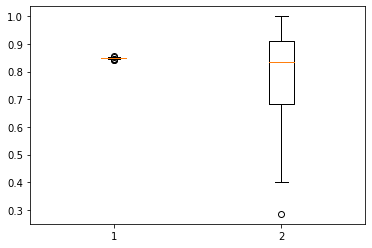

In [13]:
plt.boxplot(np.array(f1_metrics))
plt.show()

<IPython.core.display.Javascript object>

(array([ 1.,  2.,  0.,  2.,  5.,  5.,  7.,  6., 11., 11.]),
 array([0.28571429, 0.35714286, 0.42857143, 0.5       , 0.57142857,
        0.64285714, 0.71428571, 0.78571429, 0.85714286, 0.92857143,
        1.        ]),
 <BarContainer object of 10 artists>)

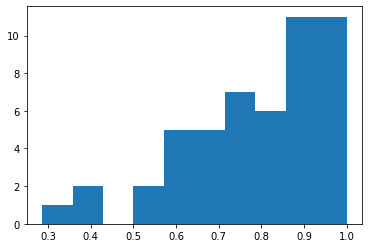

In [14]:
plt.hist(np.array(f1_metrics)[:,1])

In [15]:
np.median(np.array(f1_metrics)[:,1])

0.8345771144278606

In [16]:
def sensitivity(y_true, y_pred):
    TP = np.sum(y_true & y_pred)
    FN = np.sum(y_true&(~y_pred))
    if TP + FN == 0:
        return 0
    return TP/(TP + FN)

F1 0.8615134886350362 0.9393382352941176


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

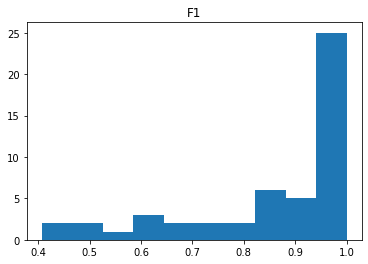

#FP 292.66 212.5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

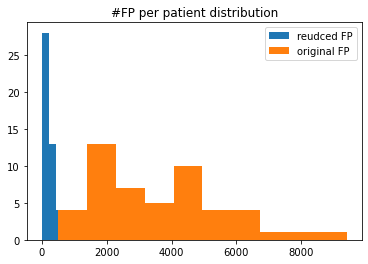

In [17]:
all_f1 = [sensitivity(x, y) for x, y in full_test_prediction]
print('F1', np.mean(all_f1), np.median(all_f1))
plt.hist(all_f1)
plt.title('F1')
plt.show()


FP_number_reduced = [np.sum(y&(~x)) for x, y in full_test_prediction]
FP_number_original = [len(y) - np.sum(x) for x, y in full_test_prediction]
print('#FP', np.mean(FP_number_reduced), np.median(FP_number_reduced))
plt.title('#FP per patient distribution')
plt.hist(FP_number_reduced)
plt.hist(FP_number_original)
plt.legend(['reudced FP', 'original FP'])
plt.show()

## Some feature testing drafts (ignore)

### Gabor

In [9]:
from general_utils.utils import min_max_norm
from skimage import feature

In [10]:
image = db[0]['img']
# not sure if agnles are what I need to get left<->right with d=2
image_patch = min_max_norm(image[300:330, 330:360], max_val=255).astype(np.uint8) # needs conversion for GLCM generation

In [11]:
def gabor_feature_bank(scale, orientation, max_freq=0.2, ksize=(50, 50), sigma=1):
    orientations = [(i*np.pi)/orientation for i in range(orientation)]
    frequencies = [(max_freq)/(np.sqrt(2)**i) for i in range(scale)]
    gabor_kernels = []
    for orient in orientations:
        for freq in frequencies:
            gabor_kernels.append(cv2.getGaborKernel(ksize=ksize, sigma=sigma, theta=orient, lambd=1/freq, gamma=0.5, psi=0))
    
    return gabor_kernels

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

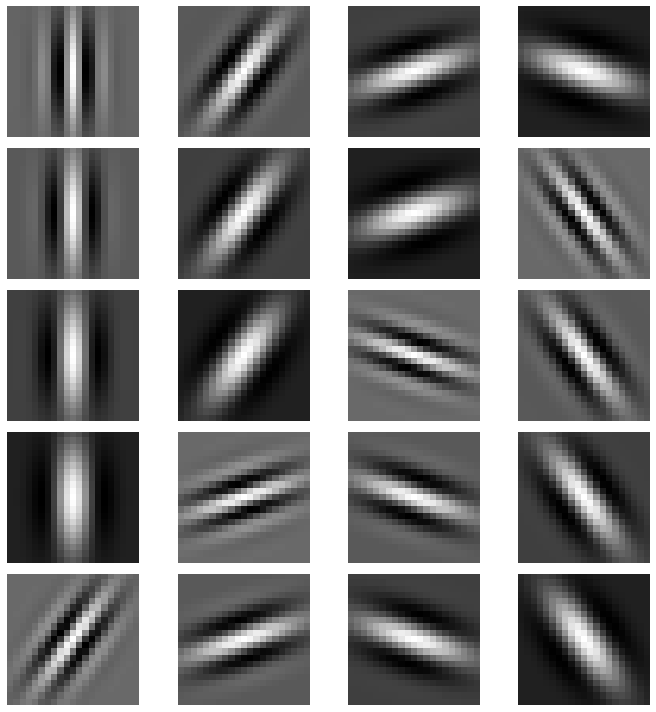

In [9]:
kerns = gabor_feature_bank(scale=4, orientation=5, max_freq=0.2, ksize=(20, 20), sigma=3)
plot_gabor_filters(kerns, plots_columns=4)

In [12]:
def gabour_features(image, patch_coords, gabor_params):
    gabor_kernels = gabor_feature_bank(**gabor_params)
    features = {}
    for kidx, k in enumerate(gabor_kernels):
        filtered_image = cv2.filter2D(image, ddepth=cv2.CV_32F , kernel=k)
        
        gf = CandidatesFeatureExtraction.first_order_statistics(filtered_image[patch_coords[0][0]:patch_coords[0][1],
                                                                               patch_coords[1][0]:patch_coords[1][1]],
                                                                flag=f'g{kidx}')  
        features = features | gf
    return features

In [13]:
gabour_features(image, [(100, 110), (200, 220)], gabor_params)

{'img_energyg0': 5346411.0,
 'img_entropyg0': 7.643856189774659,
 'img_uniformityg0': 0.005000000000000001,
 'img_ming0': -91.93469,
 'img_10th_percg0': -51.36944580078124,
 'img_90th_percg0': 267.2617645263672,
 'img_maxg0': -51.36944580078124,
 'img_meang0': 109.50778,
 'img_meadiang0': 110.487946,
 'img_inter_quartile_rangeg0': 148.52622318267822,
 'img_rangeg0': 40.56524658203126,
 'img_mean_abs_deviationg0': 94.7519921875,
 'img_robust_mean_abs_deviationg0': 66.30067138671875,
 'img_rmsg0': 163.49940366863729,
 'img_stdg0': 121.40881,
 'img_skewg0': 0.45761913350027317,
 'img_kurtg0': -0.1294826345846003,
 'img_energyg1': 2762324200.0,
 'img_entropyg1': 7.643856189774659,
 'img_uniformityg1': 0.005000000000000001,
 'img_ming1': 3276.7466,
 'img_10th_percg1': 3467.05166015625,
 'img_90th_percg1': 4004.3506103515624,
 'img_maxg1': 3467.05166015625,
 'img_meang1': 3710.8289,
 'img_meadiang1': 3699.3433,
 'img_inter_quartile_rangeg1': 262.61328125,
 'img_rangeg1': 190.3050781249999,
 

### LBP

In [93]:
from skimage.feature import local_binary_pattern

In [98]:
image_patch = image[200:300, 300:400]

In [ ]:
lbp_params = {'P':16, 'R':14, 'method':'uniform'}

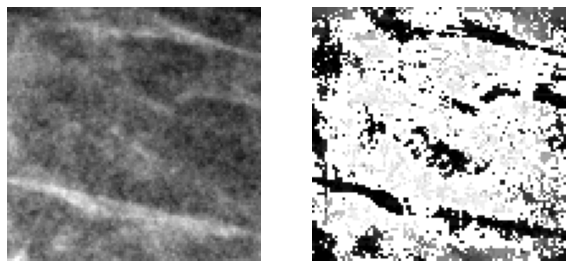

In [107]:
simple_im_show2(image_patch, local_binary_pattern(image_patch, P=16, R=14, method='uniform'))